In [5]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("/home/yasser/classes/DL26/final_Project")

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

to_tensor = T.ToTensor()

def psnr(sr, hr):
    mse = np.mean((sr - hr) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(1.0 / np.sqrt(mse))


def compare_sr_models(
    hr_path,
    srresnet_model,
    scale=4
):
    srresnet_model.eval()

    # LOAD HR
    hr_img = Image.open(hr_path).convert("RGB")
    hr_tensor = to_tensor(hr_img).unsqueeze(0).to(device)

    # GENERATE LR SYNTHETIC
    lr_img = hr_img.resize(
        (hr_img.width // scale, hr_img.height // scale),
        Image.BICUBIC
    )
    lr_tensor = to_tensor(lr_img).unsqueeze(0).to(device)

    # BICUBIC UPSCALE
    bicubic_tensor = F.interpolate(
        lr_tensor,
        scale_factor=scale,
        mode="bicubic",
        align_corners=False
    )

    # srresnet
    with torch.no_grad():
        srresnet = srresnet_model(lr_tensor)


    # TO NUMPY
    hr_np       = hr_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
    bicubic_np  = bicubic_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
    srresnet_np  = srresnet.squeeze(0).permute(1,2,0).cpu().numpy()

    lr_np       = lr_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

    # PSNR
    psnr_bic  = psnr(bicubic_np, hr_np)
    psnr_srr  = psnr(srresnet_np, hr_np)


    print(" PSNR RESULTS (Synthetic LR)")
    print(f"  Bicubic : {psnr_bic:.2f} dB")
    print(f"  srresnet   : {psnr_srr:.2f} dB")


    # DISPLAY
    titles = [
        "LR (Synthetic)",
        f"Bicubic\n{psnr_bic:.2f} dB",
        f"srresnet\n{psnr_srr:.2f} dB",
        "HR (Ground Truth)"
    ]

    images = [lr_np, bicubic_np, srresnet_np, hr_np]

    plt.figure(figsize=(18, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [7]:
from src.utils.models_architecture import SRResNet

srresnet = SRResNet().to(device)
srresnet.load_state_dict(
    torch.load("src/models/checkpoints/SRESNET/best_SRESNET.pth", map_location=device)
)
srresnet.eval()

print("✔ srresnet loaded correctly")



✔ srresnet loaded correctly


/tmp/ipykernel_564420/3200255601.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("src/models/checkpoints/SRESNET/best_SRESNET.pth", map_location=device)


 PSNR RESULTS (Synthetic LR)
  Bicubic : 25.58 dB
  srresnet   : 25.29 dB


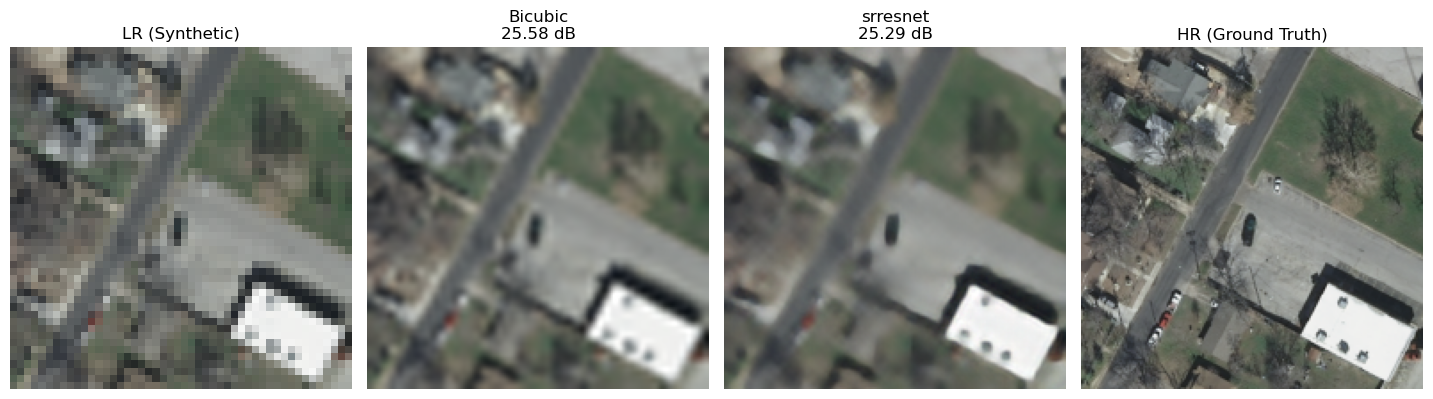

In [13]:
compare_sr_models(
    hr_path="data/preprocessed/test/HR/austin1_r03_c02.png",
    srresnet_model=srresnet,
    scale=4
)

In [9]:
compare_sr_models(
    hr_path="data/preprocessed/test/HR/austin1_r00_c04.png",
    srcnn_model=srcnn,
    edsr_model=edsr,
    scale=4
)

NameError: name 'srcnn' is not defined

In [ ]:
# test